### Intro

Here is Conor and Will's computational project. The system we are investigating is a harmonograph ($\href{https://youtu.be/HJYvc-ISrf8?si=28UPteGFD0hYIdjX}{\text{Check This Out}}$). The system distills into two coupled pendulums and a third uncoupled one.

Here is our non dimensional Lagrangian:

\begin{equation}
    L = \frac{1}{2}\rho_3\dot{\theta}^{2}_{3} + \frac{1}{2}(1+\rho_2)\gamma^{2}\dot{\theta}^{2}_{3} \(***finish?**)
\end{equation}

First, we need want to solve the double pendulum, because the single pendulum added onto it will be easy.
We want to solve the following system:

\begin{equation}
\begin{split}
           (1 + \rho_2)\ddot{\theta}_1 + \rho_2\gamma_2\cos(\theta_2 - \theta_1)\ddot{\theta}_2 - \rho_2\gamma_2\sin(\theta_2 - \theta_1)\dot{\theta}_2 = - (1+\rho_2)\sin(\theta_1)   // 
           \gamma_2\ddot{\theta}_2 + \ddot{\theta}
\end{split}
\end{equation}

In [2]:
%matplotlib widget
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

def vectorfield(w, t, p):
    """
    Defines the differential equations for the double pendulum.

    ***could modify to include the single one too!!!


    ***basically all comments are wrong!!!!!**********

    Arguments:
        w :  vector of the state variables:
                  w0 = [θ1, x1, θ2, x2, θ3, x3]
        t :  time
        p :  vector of the parameters:
                  p = [p2, g2, g3]
    """
    θ1, x1, θ2, x2, θ3, x3 = w
    p2, g2, g3 = p

    # Create f = (θ1',x1',θ2',x2',θ3',x3'):
    f = [x1, ######ADDED            vv this p2
         (p2*g2*x2**2*np.sin(θ2-θ1)+p2*x1**2*np.sin(2*(θ2-θ1))/2+p2*np.sin(θ2)*np.cos(θ2-θ1)-np.sin(θ1)) / (1-p2*np.cos(θ2-θ1)**2),
         x2,
         (x1**2*np.sin(θ2-θ1)+p2*g2*x2**2*np.sin(2*(θ2-θ1))/2-np.sin(θ1)*np.cos(θ2-θ1)+np.sin(θ2)) / (p2*g2*np.cos(θ2-θ1)**2-g2),
         x3,
         -np.sin(θ3)/g3]
    return f

def sim(ICsArray, paramArray, stoptime=10.0, numpoints=250):
    # Use ODEINT to solve the differential equations defined by the vector field
    """
    input format:
    ICsArray = [θ1, x1, θ2, x2, θ3, x3]
    θ_ are the initial angles; x_ are the initial nondiminsionalized angular velocities
    
    paramArray = [p2, g2, g3]
    p2 = "p2"/(1+"p2") = m2/(m1+m2); "p2" = m2/m1; g2=l2/l1; g3=l3/l1
    """
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    
    # Create the time samples for the output of the ODE solver.
    # I use a large number of points, only because I want to make
    # a plot of the solution that looks nice.
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

    # Call the ODE solver.
    wsol = odeint(vectorfield, ICsArray, t, args=(paramArray,), atol=abserr, rtol=relerr)
    return wsol, t, ICsArray, paramArray

#makes a simple plot of wsol and t
def θtPlot(wsol, t, showθ1=True, showθ2=True, showθ3=True):
    θ1 = wsol[:,0]
    x1 = wsol[:,1]
    θ2 = wsol[:,2]
    x2 = wsol[:,3]
    θ3 = wsol[:,4]
    x3 = wsol[:,5]
    
    lw = 1
    
    [fig, ax] = plt.subplots(1)
    
    if showθ1: ax.plot(t, θ1, 'b', linewidth=lw)
    if showθ2: ax.plot(t, θ2, 'g', linewidth=lw)
    if showθ3: ax.plot(t, θ3, 'r', linewidth=lw)
    
    ax.set_title('θ1, θ2, θ3 vs tau');
    ax.set(xlabel=r'$t$', ylabel=r'$θ$')
    
    fig.legend((r'$θ_1$', r'$θ_2$', r'$θ_3$'));
    
    return fig, ax

def phasePlot(wsol, t, showθ1=True, showθ2=True, showθ3=True, bounds=[[-np.pi, np.pi],[-np.pi, np.pi]]):
    θ1 = wsol[:,0]
    x1 = wsol[:,1]
    θ2 = wsol[:,2]
    x2 = wsol[:,3]
    θ3 = wsol[:,4]
    x3 = wsol[:,5]
    
    lw = 1

    [fig, ax] = plt.subplots(1)

    if showθ1: ax.plot(θ1, x1, 'b', linewidth=lw, label=r'$θ_1$')
    if showθ2: ax.plot(θ2, x2, 'r', linewidth=lw, label=r'$θ_2$')
    if showθ3: ax.plot(θ3, x3, 'g', linewidth=lw, label=r'$θ_3$')
    ax.set_title(r'$θ$ vs $\dot{θ}$');
    ax.set(xlim=bounds[0], ylim=bounds[1], xlabel=r'$θ$', ylabel=r'$\dot{θ}$')
    
    
    fig.legend();
    return fig, ax

#makes a simple animation of θ1 vs θ3, to emulate harmonograph drawings.
#notably, inputs a LIST of wsols, so if you only want to do one you still
#need to put square brackets around it.
def harmAni(wsols, bounds=[[-np.pi, np.pi],[-np.pi, np.pi]], title=""):
    numpaths = len(wsols)
    θ1s = [wsol[:,0] for wsol in wsols]
    θ3s = [wsol[:,4] for wsol in wsols]
    
    fig, ax = plt.subplots()
    paths = [ax.plot(θ1s[i][0], θ3s[i][0], label="wsol#"+str(i))[0] for i in range(numpaths)]
    ax.set(xlim=bounds[0], ylim=bounds[1], xlabel=r'$θ_1$', ylabel=r'$θ_3$')
    ax.legend()
    ax.set_title("$θ_1$ vs $θ_3$" + (", "*bool(title)) + title)

    def update(frame):
        for i in range(numpaths):
            paths[i].set_xdata(θ1s[i][:frame])
            paths[i].set_ydata(θ3s[i][:frame])
        return paths

    return FuncAnimation(fig=fig, func=update, frames=len(θ1s[0]), interval=5)

In [6]:
plt.close("all")

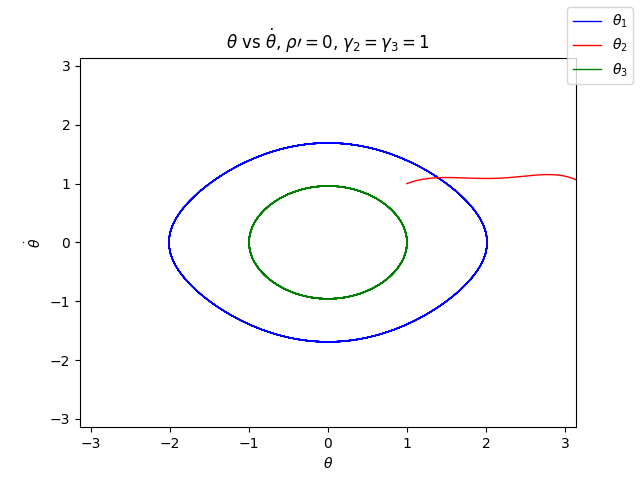

In [7]:
wsol, t, *x = sim([1.5,1,1,1,1,0], [0,1,1], stoptime=50.0, numpoints = 1000)
f,a=phasePlot(wsol, t, showθ2=True, showθ3=True)
a.set_title(r'$θ$ vs $\dot{θ}$, $\rho\prime=0$, $γ_2=γ_3=1$');
# wsol, t = sim([.5,0,1.75,0,1,0], [.5,1,1], stoptime=100.0, numpoints = 1000)
# phasePlot(wsol, t);

MovieWriter ffmpeg unavailable; using Pillow instead.


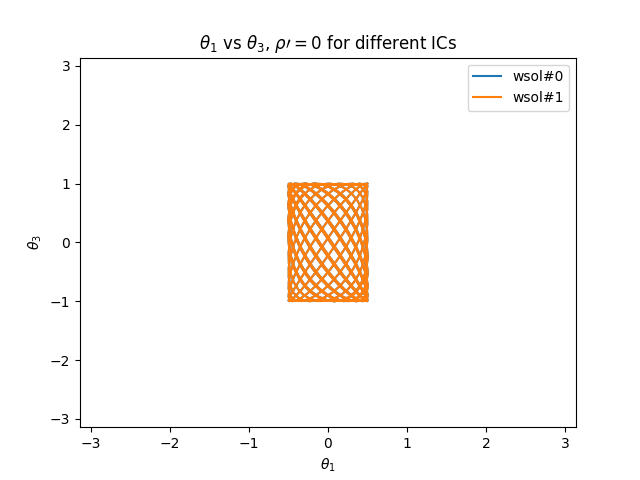

In [32]:
plt.close("all")
wsol1, t1, *x = sim([.5,0,1.25,0,1,0], [0,1,1], stoptime=100.0, numpoints = 500)
wsol2, t2, *x = sim([.5,0,1.75,0,1,0], [0,1,1], stoptime=100.0, numpoints = 500)
ani = harmAni([wsol1, wsol2], title=r"$\rho\prime=0$ for different ICs")
ani.save("rho=0.gif")

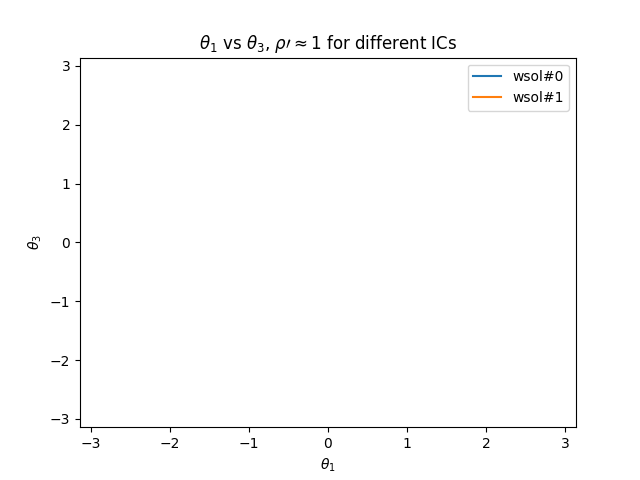

In [7]:
plt.close("all")
wsol1, t1, *x = sim([.5,0,0.75,0,1,0], [.999,1,1], stoptime=10.0, numpoints = 1000)
wsol2, t2, *x = sim([.5,0,0.75,0,1,0], [.99,1,1], stoptime=10.0, numpoints = 1000)
ani = harmAni([wsol1, wsol2], title=r"$\rho\prime=0.999 and \rho\prime=0.99$")
ani.save("rho=ish1.gif")

In [ ]:
#makes a simple animation of θ1 vs θ3, to emulate harmonograph drawings.
#notably, inputs a LIST of wsols, so if you only want to do one you still
#need to put square brackets around it.
def harmAni(wsols, bounds=[[-np.pi, np.pi],[-np.pi, np.pi]]):
    numpaths = len(wsols)
    θ1s = [wsol[:,0] for wsol in wsols]
    θ3s = [wsol[:,4] for wsol in wsols]
    
    fig, ax = plt.subplots()
    paths = [ax.plot(θ1s[i][0], θ3s[i][0], label="wsol#"+str(i))[0] for i in range(numpaths)]
    ax.set(xlim=bounds[0], ylim=bounds[1], xlabel=r'$θ_1$', ylabel=r'$θ_3$')
    ax.legend()

    def update(frame):
        for i in range(numpaths):
            paths[i].set_xdata(θ1s[i][:frame])
            paths[i].set_ydata(θ3s[i][:frame])
        return paths

    return FuncAnimation(fig=fig, func=update, frames=len(θ1s[0]), interval=5)

In [ ]:
plt.close("all")
wsol1, t1, *x = sim([.5,0,1.25,0,1,0], [0,1,1], stoptime=50.0, numpoints = 250)
wsol2, t2, *x = sim([.5,0,1.75,0,1,0], [0,1,1], stoptime=50.0, numpoints = 250)
phasePlot(wsol1, t2)
phasePlot(wsol2, t2)

In [ ]:
plt.close("all")
wsol1, t1, *x = sim([.49,0,1.75,0,1,0], [.5,1,1], stoptime=50.0, numpoints = 250)
wsol2, t2, *x = sim([.51,0,1.75,0,1,0], [.5,1,1], stoptime=50.0, numpoints = 250) #makes a heart-shape, sort of!
ani = harmAni([wsol1, wsol2])

In [ ]:
#do not touch, it makes a heart.
plt.close("all")
wsol2, t2, *x = sim([.51,0,1.75,0,1,0], [.5,1,1], stoptime=100.0, numpoints = 1000)
ani = harmAni([wsol2])
ani.save("heartHarm.gif")

In [ ]:
#eye, ish!
plt.close("all")
wsol2, t2, *x = sim([0.5,0,0.5,0,0,0.5], [0.01,1,1], stoptime=100.0, numpoints = 1000)
ani = harmAni([wsol2], bounds=[[-1,1],[-1,1]])

In [ ]:
wsol, t, *x = sim([.51,0,1.75,0,1,0], [.5,1,1], stoptime=100.0, numpoints = 1000)
phasePlot(wsol, t, showθ2=False, showθ3=False);
wsol, t, *x = sim([.5,0,1.75,0,1,0], [.5,1,1], stoptime=100.0, numpoints = 1000)
phasePlot(wsol, t);

In [ ]:
plt.close("all")

In [ ]:
θtPlot(wsol1, t1)
θtPlot(wsol2, t2)

In [ ]:
wsol, t, *x = sim([.5,0,2.25,0,1,0], [.5,1,1], stoptime=50.0, numpoints = 250)
ani = harmAni([wsol])

In [ ]:
wsol, t, *x = sim([.5,0,2.25,0,1,0], [.5,1,1])
# θtPlot(wsol, t)

fig1, ax1 = plt.subplots(1)
θ1 = wsol[:,0]
x1 = wsol[:,1]
θ2 = wsol[:,2]
x2 = wsol[:,3]
θ3 = wsol[:,4]
x3 = wsol[:,5]
ax1.plot(θ1, θ3, 'b', linewidth=1)


In [ ]:
wsol, t, *x = sim([1,0,2.25,0,1,0], [.5,1,1])
θtPlot(wsol, t)

In [ ]:
#demonstration of chaos
wsol, t, *x = sim([1,0,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)
wsol, t, *x = sim([1.01,0,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)
wsol, t, *x = sim([1.0,0.01,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)

In [ ]:
#note that the stuff from theta3 does have an effect on theta 1 and 2, but I'm
#pretty sure that this is just because of numerical error in the DE solver,
#since these very different conditions for theta 3 only show divergence in theta1
#and theta2 after like tau=50, which is comparable/even higher than how long it
#takes when I add a miniscule amt. to the theta1 or theta2 ICs.
wsol, t, *x = sim([1,0,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)
wsol, t, *x = sim([1,0,2.25,0,5,2], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)

In [ ]:
wsol, t, *x = sim([1,0,0,0,1.5,0], [0,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)

wsol, t, *x = sim([1,0,1,0,1.5,0], [0,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)



In [ ]:
#TOOD: better captions / titles / etc on graphs